---
# Boilerplate

In [1]:
# Typical imports
import numpy as np
from scipy.spatial import Delaunay
from skimage.draw import polygon2mask
from skimage.draw import polygon
from scipy.interpolate import RegularGridInterpolator
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from pylab import *
import cv2
import math
import sys
import os
import glob
from collections import defaultdict
import imageio 
print(sys.version)

3.11.4 (main, Jul  5 2023, 08:40:20) [Clang 14.0.6 ]


# For updating my helper functions (sometimes you need to run this block twice)

In [2]:
# My own helper functions
import julians_little_helpers 
from julians_little_helpers import * 
# For reloading my helper functions when I make changes to them
import importlib
importlib.reload(julians_little_helpers)

<module 'julians_little_helpers' from '/Users/julian/Code/cs180/proj4/code/julians_little_helpers.py'>

--- 
# Project 4A

# The photos I took to be stitched:

In [5]:
ims = []
filenames = sorted(glob.glob('../data/*.png'))
for filename in filenames:
    im = read_im(filename)
    ims.append(im)


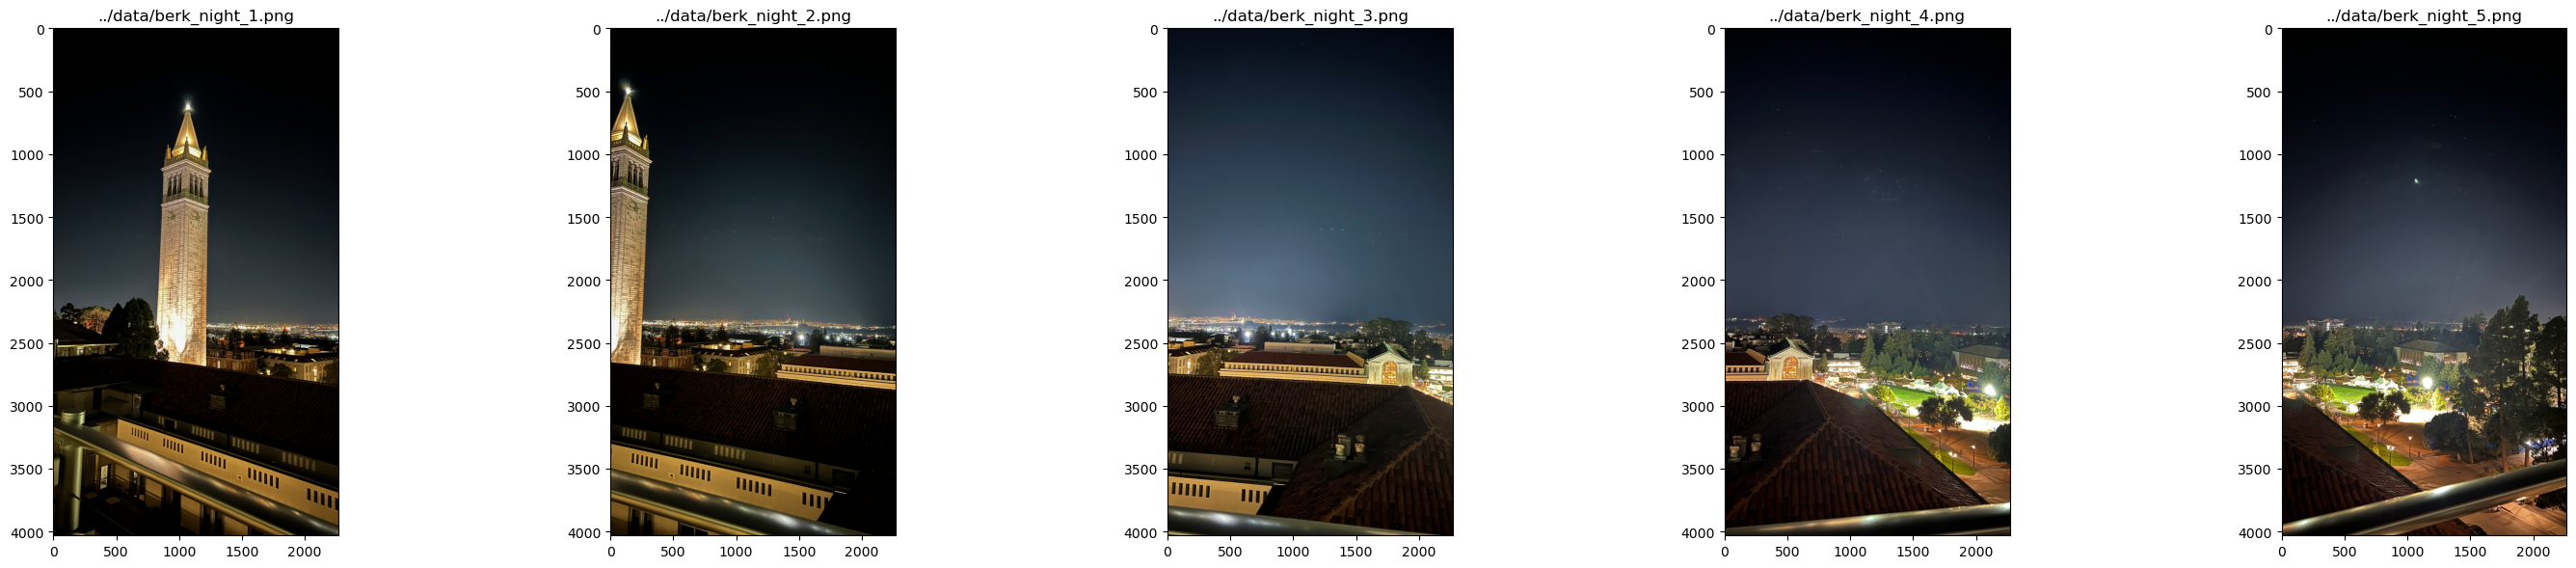

In [6]:
DisplayImages(ims, filenames, 6)

# Recovering Homographies
$$
p' = Hp
$$ 
Where H is a 3x3 matrix (with 8 degrees of freedom), p is a point in the original image, and p' is the point in the new image.
Will need to write a function that recovers the homography via a set of corresponding points $(p, p')$. 

`H = computeH(im1_pts, im2_pts)`

Where `im1_pts` and `im2_pts` are n by 2 matrices of corresponding points in the two images.

In order to solve for the entries of matrix `H` we will need to setup a linear system of n equations, which can be written as 
$$Ah = b$$ 
where $h$ is a vector of the 8 entries of `H`. More than 4 correspondances should be provided to produce an overdetermined system which can be solved using least squares. (This will be more stable than if we chose 4 correspondances and solved using a direct method.)

For the purposes of the first part of this project, I will manually determine the correspondancs using a tool like [GIMP](https://www.gimp.org/).

For `computeH()` I will probably use `np.linalg.lstsq()` or `scipy.optimize.least_squares()` or `scipy.optimize.nnls()` probably using a contraint on `h` to make it have magnitude of 1. As of right now I'm not entirely sure if I need to constrain it or not.

In [35]:
def computeH(im1_pts, im2_pts):
    """
    Inputs:
        im1_pts: nx2 matrix of points from image 1 (x,y).
        im2_pts: nx2 matrix of points from image 2 (x,y).
        n >= 4 
    Returns:
        H: 3x3 Homography matrix from image 1 to image 2.
    Strategy:
        A = [[x y 1 0 0 0 -x*x' -y*x']
             [0 0 0 x y 1 -x*y' -y*y']
             [          .            ]
             [    .     .       .    ]
             [  .       .         .  ]
             [.        ...          .]] 
        h = [a b c d e f g h]^T
        b = [x' y' ...]^T
        Solve Ah = b for h.
        Reshape to 3x3.
    """
    # Solve the linear system Ah = b
    A = np.zeros((2*im1_pts.shape[0], 8))
    b = np.zeros((2*im1_pts.shape[0], 1))
    for i in range(im1_pts.shape[0]):
        x1, y1 = im1_pts[i]
        x2, y2 = im2_pts[i]
        A[2*i,   :] = np.array([x1, y1, 1,  0,  0, 0, -x1*x2, -y1*x2])
        A[2*i+1, :] = np.array([ 0,  0, 0, x1, y1, 1, -x1*y2, -y1*y2])
        b[2*i,   :] = x2
        b[2*i+1, :] = y2
    h = np.linalg.lstsq(A, b, rcond=None)[0]
    h = np.append(h, 1)
    H = h.reshape((3,3))
    return H

In [36]:
# Test computeH
im1_pts = np.array([[1, 1], [1, 2], [2, 1], [2, 2]])
im2_pts = np.array([[2, 2], [2, 3], [3, 2], [3, 3]])
H = computeH(im1_pts, im2_pts)
H_inv = np.linalg.inv(H)
for i in range(im1_pts.shape[0]):
    assert np.allclose(H @ np.append(im1_pts[i], 1), np.append(im2_pts[i], 1))
    assert np.allclose(np.append(im1_pts[i], 1), H_inv @ np.append(im2_pts[i], 1))

# Manually get correspondences.
# For simplicity's sake, I will just stitch 2 images together for now.

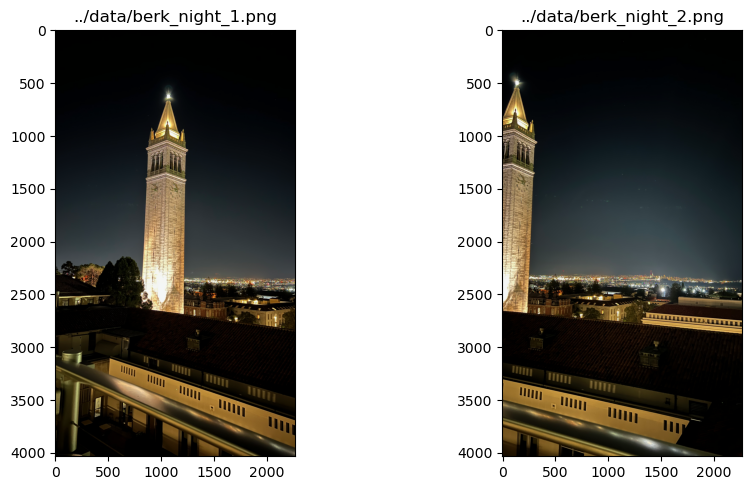

(4032, 2268, 3) (4032, 2268, 3)


In [9]:
DisplayImages(ims[:2], filenames[:2], 5)
im1, im2 = ims[:2]
print(im1.shape, im2.shape)

In [75]:
# (x,y) format (0,0) is top left
im1_pts = [
    [1075,  537], # very top of campinele
    [1057, 1040], # middle corner of ledge on campinele
    [1354, 3424], # top left corner of window to the left of white box
    [2086, 2759], # bottom right corner of bright window on wheeler
]
"""
    [2047, 3757], # bottom right corner of leftmost window of the the last row of windows on lower building
    [1656, 3529], # top right corner of 3rd window to the right of white box
    [1032, 3380], # bottom right corner of 1st window of row of windows 2nd to the left of the white box
    [1357, 2438], # bottom right corner of church tower
    [1244, 2663],
    [1239, 2912],
    [1367, 2938],
]
"""
"""
    [],
    [],
    [],
    [],
    [],
    [],
]
"""

'\n    [],\n    [],\n    [],\n    [],\n    [],\n    [],\n]\n'

In [76]:
# (x,y) format (0,0) is top left
im2_pts = [
    [148, 403],
    [116, 935],
    [358, 3421],
    [1097, 2706],
]
"""
    [1555, 3791],
    [663, 3491],
    [8, 3415],
    [400, 2416],
    [269, 2651],
    [254, 2907],
    [390, 2925],

] """
"""
    [],
    [],
    [],
    [],
    [],
]
"""

'\n    [],\n    [],\n    [],\n    [],\n    [],\n]\n'

# Test that the homography works

In [189]:
im1_pts = np.array(im1_pts)
im2_pts = np.array(im2_pts)
H = computeH(im1_pts, im2_pts)
print('H:\n',H)
H_inv = computeH(im2_pts, im1_pts)
print('H_inv:\n', H_inv)
for i in range(im1_pts.shape[0]):
    im1_pt = np.append(im1_pts[i], 1)
    im2_pt = np.append(im2_pts[i], 1)
    im1_pt_t = H @ im1_pt
    im1_pt_t = im1_pt_t / im1_pt_t[2]
    im2_pt_t = H_inv @ im2_pt
    im2_pt_t = im2_pt_t / im2_pt_t[2]
    assert np.allclose(im1_pt_t, im2_pt)
    assert np.allclose(im2_pt_t, im1_pt)

H:
 [[ 1.09538008e+00 -2.72206109e-02 -1.00801150e+03]
 [ 7.34461928e-02  1.11097227e+00 -2.53745684e+02]
 [ 4.19286048e-05  2.94145982e-06  1.00000000e+00]]
H_inv:
 [[ 9.12040110e-01  1.98989796e-02  9.24396199e+02]
 [-6.89826086e-02  9.33309425e-01  1.67287976e+02]
 [-3.80376596e-05 -3.57962871e-06  1.00000000e+00]]


## Test that it works for the coords switched to $(y,x)$ format.

In [190]:
im1_pts_yx = im1_pts[:, [1, 0]]
im2_pts_yx = im2_pts[:, [1, 0]]
H2 = computeH(im1_pts_yx, im2_pts_yx)
print('H2:\n',H2)
H2_inv = computeH(im2_pts_yx, im1_pts_yx)
print('H2_inv:\n', H2_inv)
for i in range(im1_pts_yx.shape[0]):
    im1_pt = np.append(im1_pts_yx[i], 1)
    im2_pt = np.append(im2_pts_yx[i], 1)
    im1_pt_t = H2 @ im1_pt
    im1_pt_t = im1_pt_t / im1_pt_t[2]
    im2_pt_t = H2_inv @ im2_pt
    im2_pt_t = im2_pt_t / im2_pt_t[2]
    assert np.allclose(im1_pt_t, im2_pt)
    assert np.allclose(im2_pt_t, im1_pt)

H2:
 [[ 1.11097227e+00  7.34461923e-02 -2.53745683e+02]
 [-2.72206109e-02  1.09538008e+00 -1.00801150e+03]
 [ 2.94145986e-06  4.19286046e-05  1.00000000e+00]]
H2_inv:
 [[ 9.33309426e-01 -6.89826089e-02  1.67287976e+02]
 [ 1.98989797e-02  9.12040110e-01  9.24396199e+02]
 [-3.57962865e-06 -3.80376598e-05  1.00000000e+00]]


# Warp one of the images to the other
## I will warp image 1 to image 2

In [194]:
def get_interpolator(im):
    x_dim = np.arange(0, im.shape[1])
    y_dim = np.arange(0, im.shape[0])

    r_interpolator = RegularGridInterpolator((y_dim, x_dim), im[:,:,0], method='linear', bounds_error=False, fill_value=None)
    g_interpolator = RegularGridInterpolator((y_dim, x_dim), im[:,:,1], method='linear', bounds_error=False, fill_value=None)
    b_interpolator = RegularGridInterpolator((y_dim, x_dim), im[:,:,2], method='linear', bounds_error=False, fill_value=None)

    def interpolate_rgb(yx_coord):
        r = r_interpolator(yx_coord)
        g = g_interpolator(yx_coord)
        b = b_interpolator(yx_coord)
        return np.column_stack((r, g, b))
    
    return interpolate_rgb
# Remember how to do inverse warp
def inverse_warp(im, target_shape, im_pts, target_pts):
    """
    Inputs:
        im: 3 channel image
        target_shape: shape of the target image
        im_pts, target_pts: nx2 matrices of correspondences from image and target (x,y).
    Returns:
        im transformed by H
    """


    # The interpolator that will get the pixel values for our inverse coordinates.
    interpolate_rgb = get_interpolator(im)

    # Convert the points from (x,y) format to (y,x) format.
    im_pts = im_pts[:, [1, 0]]
    target_pts = target_pts[:, [1, 0]]

    # Compute the homography from target to im.
    H = computeH(target_pts, im_pts)
    print(f"H:\n{H}")

    # Calculate the size and shape of the resulting transformed image.
    original_bounds = np.array([[0, 0], [target_shape[0], target_shape[1]]])
    transformed_bounds = H @ np.column_stack((original_bounds, np.ones((2,1)))).T
    transformed_bounds = transformed_bounds.T
    print(f"transformed_bounds: \n{transformed_bounds}")
    transformed_bounds[0] = transformed_bounds[0] / transformed_bounds[0][2]
    transformed_bounds[1] = transformed_bounds[1] / transformed_bounds[1][2]
    transformed_bounds = transformed_bounds[:, :2]
    print(f"original_bounds: \n{original_bounds}")
    print(f"transformed_bounds: \n{transformed_bounds}")
    print(f"transformed_bounds - original_bounds: \n{transformed_bounds - original_bounds}")
    transformed_im = np.zeros_like(im)

    # Make an array of all the pixels in the target image.
    # Calculate the inverse coordinate and interpolate the RGB values from the original image.
    target_pixels = np.array([[y, x] for y in range(im.shape[0]) for x in range(im.shape[1])])
    target_pixels_h = np.vstack((target_pixels.T, np.ones(target_pixels.shape[0])))
    inverse_pixels = H @ target_pixels_h

    # Normalize homogenous coordinates.
    for pixel in inverse_pixels.T:
        pixel /= pixel[2]

    # Remove homogenous coordinate and take transpose to put in nx2 format that RegularGridInterpolator can use. 
    inverse_pixels = inverse_pixels[:2, :].T
    interpolated_pixels = interpolate_rgb(inverse_pixels)

    transformed_im[target_pixels[:, 0], target_pixels[:, 1]] = interpolated_pixels

    return transformed_im

In [195]:
# Testing inverse_warp
warped_im = inverse_warp(ims[0], ims[1].shape, im1_pts, im2_pts)

H:
[[ 9.33309426e-01 -6.89826089e-02  1.67287976e+02]
 [ 1.98989797e-02  9.12040110e-01  9.24396199e+02]
 [-3.57962865e-06 -3.80376598e-05  1.00000000e+00]]
transformed_bounds: 
[[1.67287976e+02 9.24396199e+02 1.00000000e+00]
 [3.77393902e+03 3.07313585e+03 8.99297525e-01]]
original_bounds: 
[[   0    0]
 [4032 2268]]
transformed_bounds: 
[[ 167.28797555  924.39619859]
 [4196.54109785 3417.2626627 ]]
transformed_bounds - original_bounds: 
[[ 167.28797555  924.39619859]
 [ 164.54109785 1149.2626627 ]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>


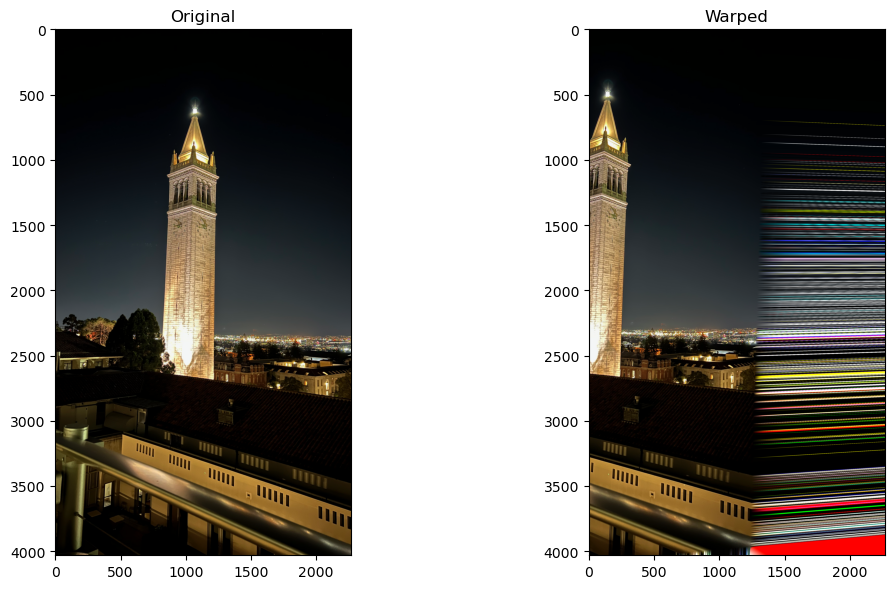

In [196]:
print(type(warped_im))
Display2Images(ims[0], warped_im,  'Original', 'Warped',  6)

# Warp image attempt 2

In [215]:
def forwardWarpImage(im, H):
    """
    Inputs:
        im: 3 channel image
        H: 3x3 homography matrix that maps points in im to points in the target image.
    Returns:
        im transformed by H using forward warping.
    """
    # Calculate all of the pixels in the target image.
    source_pixels = np.array([[y, x] for y in range(im.shape[0]) for x in range(im.shape[1])])
    target_pixels = H @ np.vstack((source_pixels.T, np.ones(source_pixels.shape[0])))
    target_pixels = target_pixels[:2, :].T.astype(int)
    # Calculate the bounds of the new image.
    top_left = H @ np.array([0, 0, 1]).T
    bottom_right = (H @ np.array([im.shape[0], im.shape[1], 1]).T).astype(int)
    height_t = int(bottom_right[0] - top_left[0])
    width_t = int(bottom_right[1] - top_left[1])
    print(f"top_left: {top_left}, bottom_right: {bottom_right}")
    print(f"height_t: {height_t}, width_t: {width_t}")
    im_t = np.zeros((max(height_t, im.shape[0]), max(width_t, im.shape[1]), 3))
    print(im.shape)
    print(im_t.shape)
    im_t[target_pixels[:, 0], target_pixels[:, 1]] = im[source_pixels[:, 0], source_pixels[:, 1]]
    return im_t

In [216]:
# Testing forwardWarpImage
# Compute the homography from im[0] to im[1].
H = computeH(im1_pts_yx, im2_pts_yx)
fwarp_im = forwardWarpImage(ims[0], H)

top_left: [-2.53745683e+02 -1.00801150e+03  1.00000000e+00], bottom_right: [4392 1366    1]
height_t: 4645, width_t: 2374
(4032, 2268, 3)
(4645, 2374, 3)


In [217]:
# What are the bounds of the new image?
original_bounds = np.array([[0, 0], [ims[1].shape[0], ims[1].shape[1]]])
print(original_bounds)
transformed_bounds = H @ np.column_stack((original_bounds, np.ones((2,1)))).T
transformed_bounds = transformed_bounds.T[:, :2]
print(transformed_bounds)

[[   0    0]
 [4032 2268]]
[[ -253.7456834  -1008.01149834]
 [ 4392.27048568  1366.55701333]]


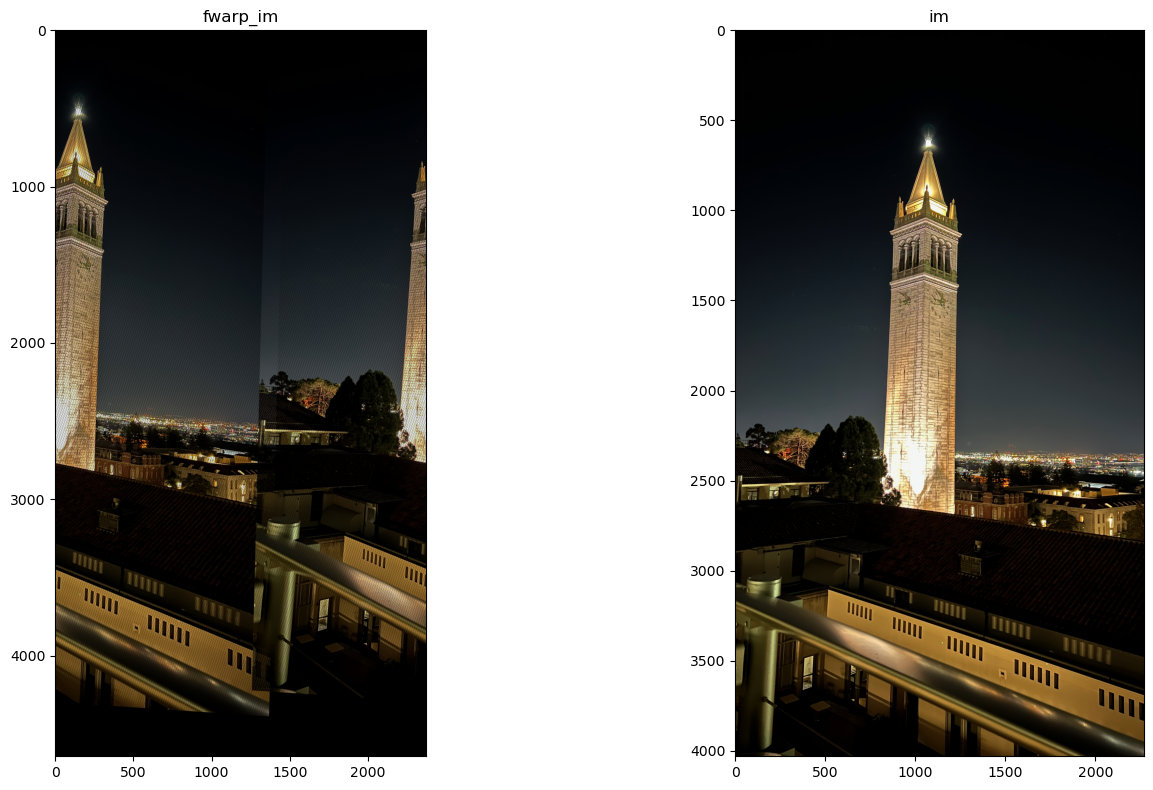

In [218]:
DisplayImages([fwarp_im, ims[0]], ['fwarp_im', 'im'], 8)

# Let's try inverse warping again

## The problem I'm having is that I was confused about where I should be placing the pixels in the resulting image. I was placing them in the wrong place. I was placing them in the place that they would be in the original image, not the warped image. I think I have it figured out now. I will try to implement it.

## Remember to look at the notes I wrote during office hours and the diagrams I drew. I need to make an oversized image, and then start placing the pixels with a certain offset so that they all fit into the image. 

In [227]:
def inverseWarpImage(im, H):
    """
    Inputs:
        im: 3 channel image
        H: 3x3 homography matrix that maps points in the target image to the points in the original image.
    Returns:
        im transformed by H using inverse warping.
    """
    # Interpolator for sampling the original image.
    interpolator = get_interpolator(im)
    # Assumption: H maps target to original.  
    # Assumption: H dotted with a point in form (y, x, 1)^T gives the coordinates of the point in the original image.
    # Assumption: target and original have the same shape.
    # Calculate all of the pixels in the target image.
    target_pixels = np.array([[y, x, 1] for y in range(im.shape[0]) for x in range(im.shape[1])])
    target_pixels = target_pixels.T
    # floating point coordinates in the original image. in the form (y, x, 1)^T
    original_pixels_homogenous = H @ target_pixels
    # reformat the coordinates to be in the form (y, x, 1)
    original_pixels_cartesian = original_pixels_homogenous.T
    # normalize using homogenous components
    # TODO: optimize this by vectorizing the operation
    for pixel in original_pixels_cartesian:
        pixel /= pixel[2]
    # remove homogenous components
    original_pixels_cartesian = original_pixels_cartesian[:, :2]
    # Sample all pixels in resultant image from original.
    #debug sampled_pixels = interpolator(original_pixels_cartesian)
    # Calculate the resultant image shape as a polygon.
    top_left = original_pixels_cartesian[0]
    bottom_right = original_pixels_cartesian[-1]

    print(f"top left: {top_left}, bottom right: {bottom_right}")
    height = int(bottom_right[0] - top_left[0])
    width = int(bottom_right[1] - top_left[1]) 
    print(f"resultant shape: {(height, width)}")
    # Initialize the resultant image.
    resultant = np.zeros((height, width, 3))
    # Fill in the resultant image with the sampled values, ensuring that the indices correctly match.

    pass

In [226]:
# Testing inverseWarpImage() 
# Compute the homography from im[1] to im[0].
H = computeH(im2_pts_yx, im1_pts_yx)
iwarp_im = inverseWarpImage(ims[0], H)

top left: [167.28797555 924.39619859], bottom right: [4195.38583236 3416.06827869]
resultant shape: (4028, 2491)


# Image Rectification

# Blend Images into Mosaic

# Most Important/Coolest thing I've learned from this part?